In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *
from numba import njit

plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

/tmp/ipykernel_202240/4211290353.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [2]:
def read_inf_coords(dim, path):
    df = pd.read_csv(path, sep="\s+", header=None, comment="#")
    if dim == 1:
        df.columns = ['index', 'inf_kappa', 'inf_theta', 'inf_radius']
    else:
        cols = [f'inf_p{i}' for i in range(dim+1)]
        df.columns = ['index', 'inf_kappa', 'inf_radius', *cols] # TODO: test it
    return df


def read_all_coordinates(dim ,folder):
    ### Coordinates to load:
    # 1. Inferred coordinates of nodes in unipartite
    # 2. Inferred coordinates of nodes in unipartite (after joint maximization likelihood (JML))
    # 3. Inferred coordinates of nodes in bipartite (after JML)
    # 4. Inferred coordinates of features in bipartite (after JML)
    # 5. Inferred coordinates of nodes in bipartite
    # 6. Inferred coordinates of features in bipartite
    inf_coord_files = glob.glob(f'{folder}/*inf_coord*')
    for file in inf_coord_files:
        if 'features_le' in file:
            inf_coord_features_le = read_inf_coords(dim, file)
        elif 'nodes_le' in file:
            inf_coord_nodes_le = read_inf_coords(dim, file)
        elif 'features' in file:
            inf_coord_features = read_inf_coords(dim, file)
        elif 'nodes' in file:
            inf_coord_nodes = read_inf_coords(dim, file)
        elif '_raw' in file:
            ''
        elif 'coord_le' in file:
            inf_coord_le = read_inf_coords(dim, file)
        else:
            inf_coord = read_inf_coords(dim, file)
        
    # Merge inferred and generated coordinates
    # 1. Coordinates of nodes in unipartite
    # 2. Coordinates of nodes in bipartite
    # 3. Coordinates of features in bipartite
    df = inf_coord.merge(inf_coord_le, on='index', suffixes=('', '_le'))
    df_nodes = inf_coord_nodes.merge(inf_coord_nodes_le, on='index', suffixes=('', '_le'))
    df_features = inf_coord_features.merge(inf_coord_features_le, on='index', suffixes=('', '_le'))
    return df, df_nodes, df_features

In [3]:
p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/citeseer/"

df_S1, df_nodes_S1, df_features_S1 = read_all_coordinates(1, f"{p}/eS1")
df_S2, df_nodes_S2, df_features_S2 = read_all_coordinates(2, f"{p}/eS2")
df_S3, df_nodes_S3, df_features_S3 = read_all_coordinates(3, f"{p}/eS3")
df_S4, df_nodes_S4, df_features_S4 = read_all_coordinates(4, f"{p}/eS4")

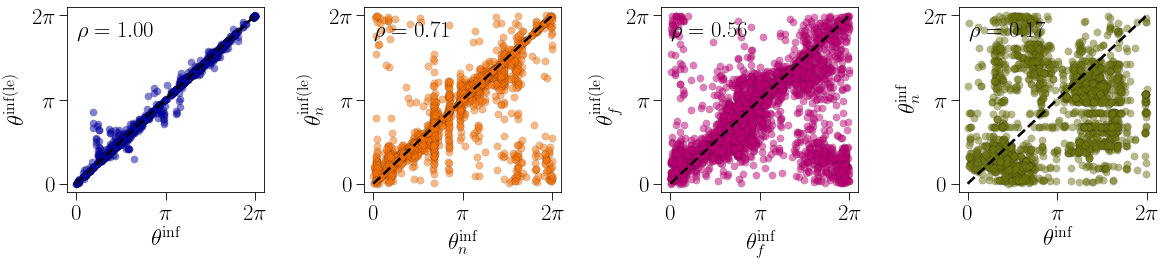

In [4]:
def plot_inf_corr_theta(df1, col1, df2, col2, color, xlabel, ylabel):
    df_merge = df1.merge(df2, on='index', suffixes=('_1', '_2'))
    plt.scatter(df_merge[f'{col1}_1'], df_merge[f'{col2}_2'], marker='.', color=color, edgecolors='black',
                lw=0.2, alpha=0.5)
    xx = np.linspace(0, 2*np.pi)
    plt.plot(xx, xx, linestyle='--', color='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([0, np.pi, 2*np.pi], ['$0$', r'$\pi$', r'$2\pi$'])
    plt.yticks([0, np.pi, 2*np.pi], ['$0$', r'$\pi$', r'$2\pi$'])
    
    res = stats.pearsonr(df_merge[f'{col1}_1'], df_merge[f'{col2}_2']).statistic
    plt.text(0.05, 0.84, rf'$\rho={{{res:.2f}}}$', fontsize=22, transform=plt.gca().transAxes, color='black')


plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plot_inf_corr_theta(df_S1, 'inf_theta', df_S1, 'inf_theta_le', 
                    'xkcd:royal blue', r'$\theta^{\mathrm{inf}}$', r'$\theta^{\mathrm{inf(le)}}$')

plt.subplot(1, 4, 2)
plot_inf_corr_theta(df_nodes_S1, 'inf_theta', df_nodes_S1, 'inf_theta_le', 
                    'xkcd:orange', r'$\theta_n^{\mathrm{inf}}$', r'$\theta_n^{\mathrm{inf(le)}}$')

plt.subplot(1, 4, 3)
plot_inf_corr_theta(df_features_S1, 'inf_theta', df_features_S1, 'inf_theta_le', 
                    'xkcd:magenta', r'$\theta_f^{\mathrm{inf}}$', r'$\theta_f^{\mathrm{inf(le)}}$')

plt.subplot(1, 4, 4)
plot_inf_corr_theta(df_S1, 'inf_theta', df_nodes_S1, 'inf_theta', 
                    'xkcd:olive', r'$\theta^{\mathrm{inf}}$', r'$\theta_n^{\mathrm{inf}}$')

plt.tight_layout()
plt.show()

In [35]:
from cmcrameri import cm
# https://www.fabiocrameri.ch/ws/media-library/ce2eb6eee7c345f999e61c02e2733962/readme_scientificcolourmaps.pdf
# https://www.nature.com/articles/s41467-020-19160-7.pdf


@njit
def compute_angle(u, v):
    a = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    if a > 1:
        a = 1
    elif a < -1:
        a = -1
    return np.arccos(a)


@njit
def fast_compute_distances(x1, x2):
    distances = []
    for i in range(len(x1)):
        for j in range(i):
            d1 = compute_angle(x1[i], x1[j])
            d2 = compute_angle(x2[i], x2[j])
            distances.append([d1, d2])
    return np.array(distances)
    

@njit
def fast_compute_distances_dim1(x1, x2):
    distances = []
    for i in range(len(x1)):
        for j in range(i):
            d1 = np.pi - np.fabs(np.pi - np.fabs(x1[i] - x1[j]))
            d2 = np.pi - np.fabs(np.pi - np.fabs(x2[i] - x2[j]))
            distances.append([d1, d2])
    return np.array(distances)
    
    
def compute_distances(df1, cols1, df2, cols2, dim):
    df_merge = df1.merge(df2, on='index', suffixes=('_1', '_2'))

    if dim == 1:
        x1 = df_merge[f'{cols1}_1'].values
        x2 = df_merge[f'{cols2}_2'].values
    else:
        x1 = df_merge[[f'{col}_1' for col in cols1]].values
        x2 = df_merge[[f'{col}_2' for col in cols2]].values
        
    # for larger networks it can be slow, sample 2k random nodes or features
    max_size = 2000
    if len(x1) > max_size:
        tmp_sub = np.random.choice(np.arange(len(x1)), size=max_size, replace=False)
        x1 = x1[tmp_sub]
        x2 = x2[tmp_sub]

    if dim == 1:
        distances = fast_compute_distances_dim1(x1, x2)
    else:
        distances = fast_compute_distances(x1, x2)
    return distances


def get_inverse_g_value(rho):
    # Fitted values obtained from synthetic networks
    a = 2.43
    b = 1.4
    g = 1 / a * np.log(1/rho - 1) + b
    return np.clip(g, 0, np.pi) # 0 - perfect correlation, pi - luck of correlation


def plot_angle_comparison(df1, cols1, df2, cols2, ax, xlabel, ylabel, dim=1):
    distances = compute_distances(df1, cols1, df2, cols2, dim)
    heatmap, xedges, yedges = np.histogram2d(distances[:, 0], distances[:, 1], bins=(50, 50))
    cax = ax.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    origin='lower', aspect='auto', cmap=cm.lipari_r)
    ax.set_xticks([0, np.pi/2, np.pi])
    ax.set_yticks([0, np.pi/2, np.pi])
    ax.set_xticklabels(['$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax.set_yticklabels(['$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    res = stats.pearsonr(distances[:, 0], distances[:, 1]).statistic
    ax.text(0.05, 0.84, rf'$\rho={{{res:.2f}}}$', fontsize=22, transform=ax.transAxes, color='black') 
    g = get_inverse_g_value(res)
    ax.text(0.05, 0.74, rf'$g={{{g:.2f}}}$', fontsize=22, transform=ax.transAxes, color='black')

CPU times: user 3.36 s, sys: 821 ms, total: 4.18 s
Wall time: 5.04 s


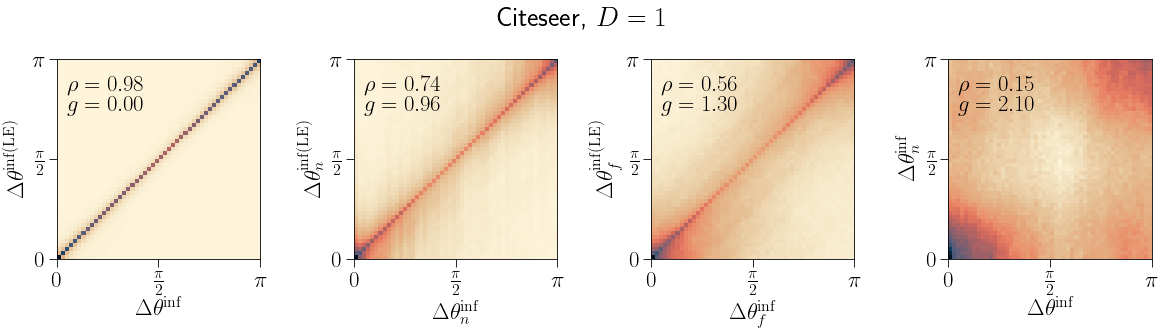

In [36]:
%%time

fig, axs = plt.subplots(1, 4, figsize=(16, 5))

dim = 1
xlabs = 'inf_theta'
ylabs = 'inf_theta_le'

plot_angle_comparison(df_S1, xlabs, df_S1, ylabs, axs[0],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta^{\mathrm{inf(LE)}}$')

plot_angle_comparison(df_nodes_S1, xlabs, df_nodes_S1, ylabs, axs[1],
                      r'$\Delta\theta_n^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf(LE)}}$')

plot_angle_comparison(df_features_S1, xlabs, df_features_S1, ylabs, axs[2],
                      r'$\Delta\theta_f^{\mathrm{inf}}$', r'$\Delta\theta_f^{\mathrm{inf(LE)}}$')

plot_angle_comparison(df_S1, xlabs, df_nodes_S1, ylabs, axs[3],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf}}$')

plt.suptitle(rf'Citeseer, $D={dim}$', y=0.92)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/citeseer_dim1.pdf")


CPU times: user 10.9 s, sys: 853 ms, total: 11.8 s
Wall time: 12.3 s


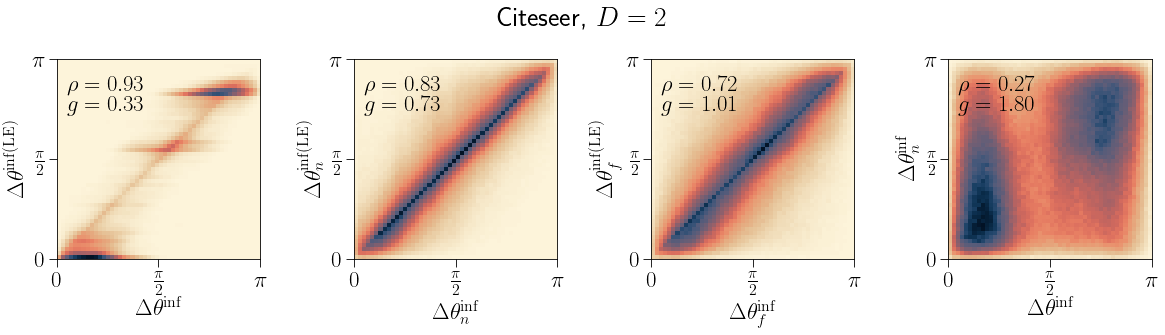

In [37]:
%%time

fig, axs = plt.subplots(1, 4, figsize=(16, 5))

dim = 2
xlabs = [f'inf_p{d}' for d in range(dim+1)]
ylabs = [f'inf_p{d}_le' for d in range(dim+1)]

plot_angle_comparison(df_S2, xlabs, df_S2, ylabs, axs[0],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta^{\mathrm{inf(LE)}}$', dim=2)

plot_angle_comparison(df_nodes_S2, xlabs, df_nodes_S2, ylabs, axs[1],
                      r'$\Delta\theta_n^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf(LE)}}$', dim=2)

plot_angle_comparison(df_features_S2, xlabs, df_features_S2, ylabs, axs[2],
                      r'$\Delta\theta_f^{\mathrm{inf}}$', r'$\Delta\theta_f^{\mathrm{inf(LE)}}$', dim=2)

plot_angle_comparison(df_S2, xlabs, df_nodes_S2, ylabs, axs[3],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf}}$', dim=2)

plt.suptitle(rf'Citeseer, $D={dim}$', y=0.92)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/citeseer_dim2.pdf")


CPU times: user 9.71 s, sys: 898 ms, total: 10.6 s
Wall time: 13.6 s


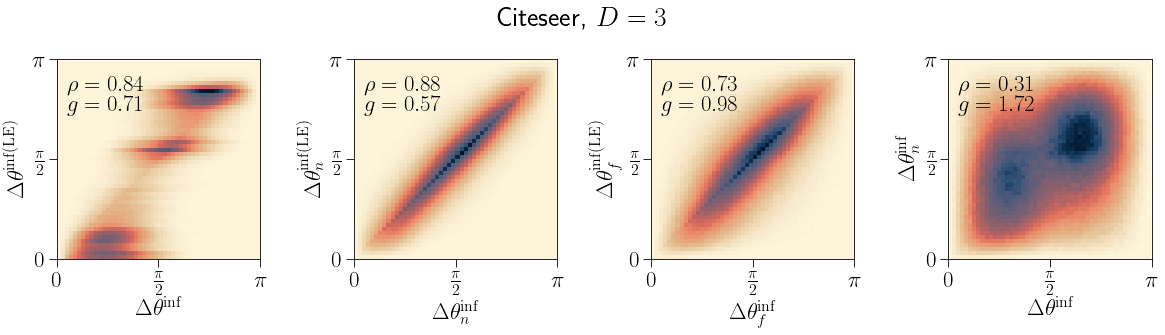

In [38]:
%%time

fig, axs = plt.subplots(1, 4, figsize=(16, 5))

dim = 3
xlabs = [f'inf_p{d}' for d in range(dim+1)]
ylabs = [f'inf_p{d}_le' for d in range(dim+1)]

plot_angle_comparison(df_S3, xlabs, df_S3, ylabs, axs[0],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_nodes_S3, xlabs, df_nodes_S3, ylabs, axs[1],
                      r'$\Delta\theta_n^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_features_S3, xlabs, df_features_S3, ylabs, axs[2],
                      r'$\Delta\theta_f^{\mathrm{inf}}$', r'$\Delta\theta_f^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_S3, xlabs, df_nodes_S3, ylabs, axs[3],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf}}$', dim=dim)

plt.suptitle(rf'Citeseer, $D={dim}$', y=0.92)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/citeseer_dim3.pdf")


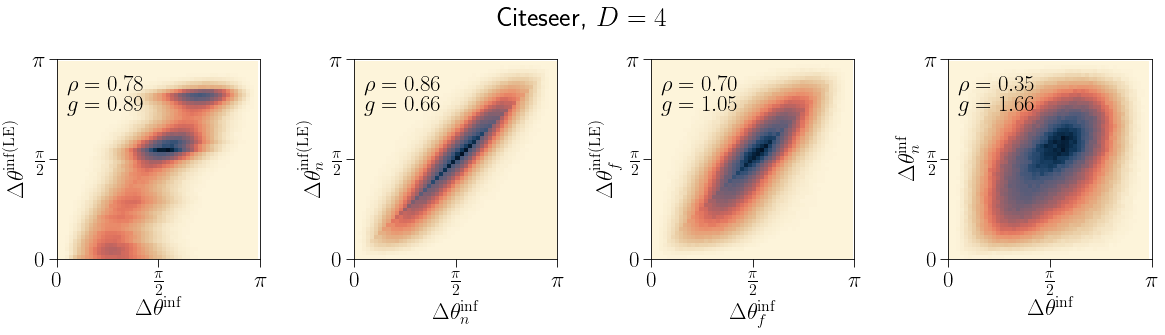

In [39]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

dim = 4
xlabs = [f'inf_p{d}' for d in range(dim+1)]
ylabs = [f'inf_p{d}_le' for d in range(dim+1)]

plot_angle_comparison(df_S4, xlabs, df_S4, ylabs, axs[0],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_nodes_S4, xlabs, df_nodes_S4, ylabs, axs[1],
                      r'$\Delta\theta_n^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_features_S4, xlabs, df_features_S4, ylabs, axs[2],
                      r'$\Delta\theta_f^{\mathrm{inf}}$', r'$\Delta\theta_f^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_S4, xlabs, df_nodes_S4, ylabs, axs[3],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf}}$', dim=dim)

plt.suptitle(rf'Citeseer, $D={dim}$', y=0.92)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/citeseer_dim4.pdf")



Compare coordinates from F-Mercator and D-Mercator (unipartite network)

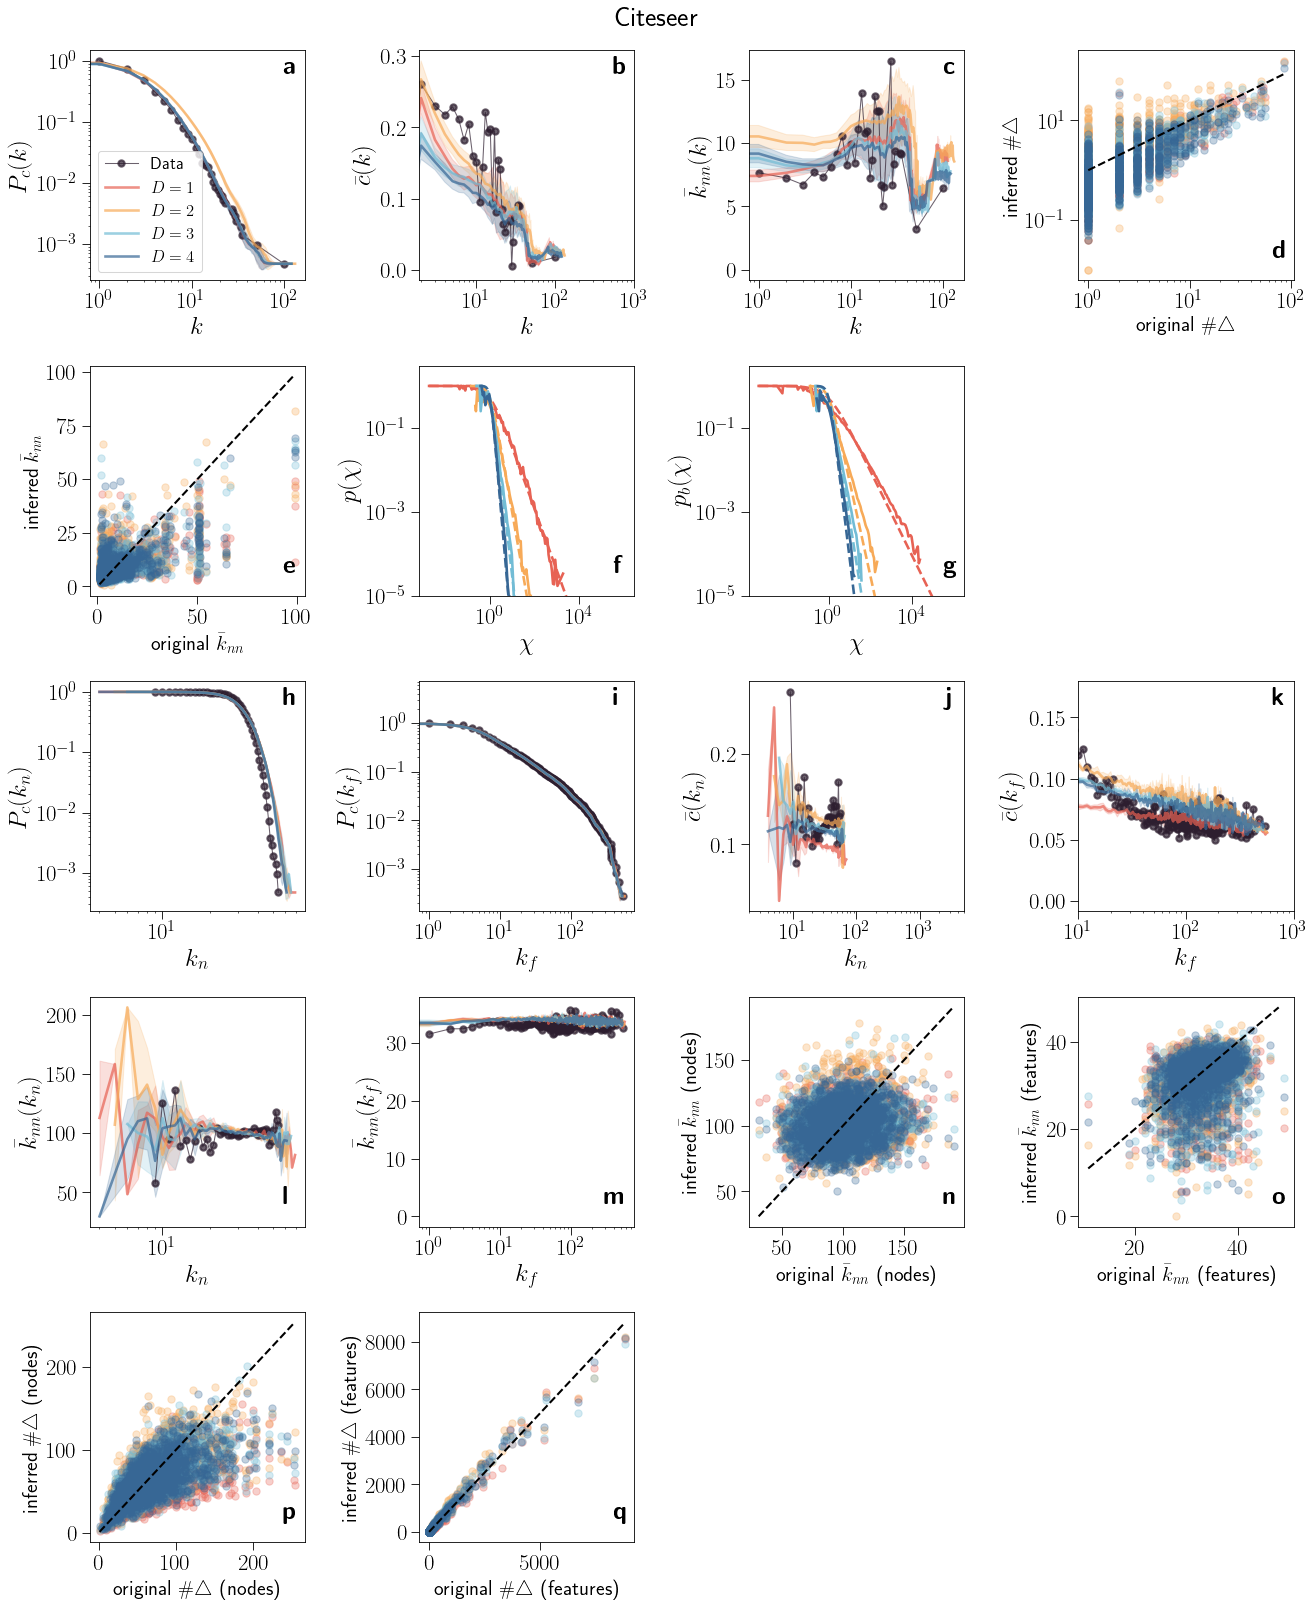

In [3]:
base_path = '/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/citeseer/'

filename = 'citeseer_GC_fixed'

paths = [f"{base_path}/eS{d}" for d in [1, 2, 3, 4]]
labels = [rf'$D={d}$' for d in [1, 2, 3, 4]]

# Unipartite
dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(paths[0], filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

# Bipartite

dfs_vstats_bipartite_nodes = [load_vstats_bipartite_nodes(p, filename) for p in paths]
dfs_vstats_bipartite_features = [load_vstats_bipartite_features(p, filename) for p in paths]

df_vprop_bipartite_nodes = [load_vprops_bipartite_nodes(p, filename) for p in paths]
df_vprop_bipartite_features = [load_vprops_bipartite_features(p, filename) for p in paths]

df_obs_bipartite_nodes = load_vstat_obs_bipartite_nodes(paths[0], filename)
df_obs_bipartite_features = load_vstat_obs_bipartite_features(paths[0], filename)
df_pconns_bipartite = [load_bipartite_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(18, 22))
plt.subplot(5, 4, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(loc='lower left', fontsize=16)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.xlim(1.9, 1000)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 4)
plot_number_of_triangles(df_vprop, labels)
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 5)
plot_sum_degree_neighbours(df_vprop, labels, log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 6)
plot_connection_probabilities(df_pconns, labels)
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

## Bipartite-S1
plt.subplot(5, 4, 7)
plot_connection_probabilities(df_pconns_bipartite, labels, ylabel=r'$p_b(\chi)$')
plt.text(0.9, 0.1, r'$\textbf{g}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 9)
plot_degree_distribution(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_n$',
                         ylabel=r'$P_c(k_n)$')
plt.text(0.9, 0.9, r'$\textbf{h}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 10)
plot_degree_distribution(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_f$',
                         ylabel=r'$P_c(k_f)$')
plt.text(0.9, 0.9, r'$\textbf{i}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 11)
plot_clustering_coefficient(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_n$',
                         ylabel=r'$\bar{c}(k_n)$')
plt.xlim(2, 5000)
plt.text(0.9, 0.9, r'$\textbf{j}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 12)
plot_clustering_coefficient(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_f$',
                         ylabel=r'$\bar{c}(k_f)$')
plt.xlim(10, 1000)
plt.text(0.9, 0.9, r'$\textbf{k}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 13)
plot_average_degree_neighbour(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels,
                              xlabel=r'$k_n$', ylabel=r"$\bar{k}_{nn}(k_n)$")
plt.text(0.9, 0.1, r'$\textbf{l}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 14)
plot_average_degree_neighbour(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels,
                              xlabel=r'$k_f$', ylabel=r"$\bar{k}_{nn}(k_f)$")
plt.text(0.86, 0.1, r'$\textbf{m}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 15)
plot_sum_degree_neighbours(df_vprop_bipartite_nodes, labels, additional_label=' (nodes)', 
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{n}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 16)
plot_sum_degree_neighbours(df_vprop_bipartite_features, labels, additional_label=' (features)',
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{o}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 17)
plot_number_of_triangles(df_vprop_bipartite_nodes, labels, additional_label=' (nodes)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{p}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 18)
plot_number_of_triangles(df_vprop_bipartite_features, labels, additional_label=' (features)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{q}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'Citeseer', y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/citeseer_topological_properties.png", dpi=300)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/citeseer_topological_properties.pdf")


In [14]:
df_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/citeseer/citeseer.content", sep="\t", header=None)
df_labels.columns = ['index', *[f'f{i}' for i in range(3703)], 'class']
df_labels.drop([f'f{i}' for i in range(3703)], axis=1, inplace=True)
df_labels.head()

/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,index,class
0,100157,Agents
1,100598,IR
2,105684,Agents
3,11099,DB
4,114091,AI


In [15]:
df_S1_merged = df_S1.merge(df_labels)
df_S1_merged.head()

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,class
0,845,4.32937,6.217310,21.3117,5.099810,6.217310,15.5170,ML
1,940,1.76332,0.937646,23.1082,3.029060,0.937646,16.5589,IR
2,1625,7.00516,5.866110,20.3493,3.029060,5.866110,16.5589,ML
3,4363,0.66343,4.232220,25.0632,0.995054,4.232220,18.7853,ML
4,5188,2.44619,1.114820,22.4535,3.029060,1.074450,16.5589,ML


In [16]:
df_nodes_S1_merged = df_nodes_S1.merge(df_labels)
df_nodes_S1_merged.head()

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,class
0,845,239.986,1.021800,19.4439,162.657,1.246280,18.8355,ML
1,940,162.516,0.519656,20.2235,124.339,0.927312,19.3728,IR
2,1625,118.678,1.660920,20.8523,113.855,1.297930,19.5489,ML
3,4363,159.832,1.767890,20.2568,185.634,1.624970,18.5712,ML
4,5188,172.984,1.665510,20.0987,174.050,1.682690,18.7001,ML


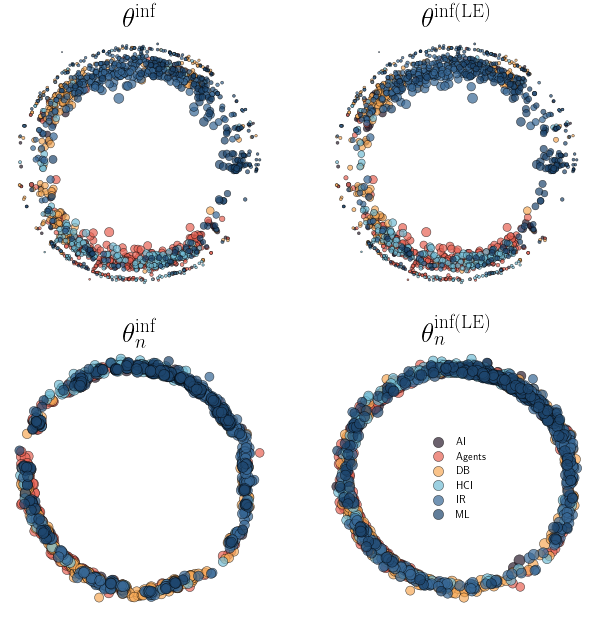

In [17]:
colormap = {label: color for color, label in zip(COLORS, np.unique(df_labels['class']))}

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for label, group in df_S1_merged.groupby('class'):
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta'])    
    axs[0, 0].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

    group['x'] = group['inf_radius'] * np.cos(group['inf_theta_le'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta_le'])    
    axs[0, 1].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)


for label, group in df_nodes_S1_merged.groupby('class'):
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta'])    
    axs[1, 0].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

    group['x'] = group['inf_radius'] * np.cos(group['inf_theta_le'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta_le'])    
    axs[1, 1].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

    
axs[0, 0].set_title(r'$\theta^{\mathrm{inf}}$')
axs[0, 1].set_title(r'$\theta^{\mathrm{inf(LE)}}$')
axs[1, 0].set_title(r'$\theta_n^{\mathrm{inf}}$')
axs[1, 1].set_title(r'$\theta_n^{\mathrm{inf(LE)}}$')

axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[1, 1].legend(fontsize=10, frameon=False)


In [18]:
names, counts =  np.unique(df_S1_merged['class'], return_counts=True)
counts = counts.astype(float)
counts /= np.sum(counts)
names, counts

(array(['AI', 'Agents', 'DB', 'HCI', 'IR', 'ML'], dtype=object),
 array([0.05512283, 0.21270222, 0.18034751, 0.15458358, 0.25104853,
        0.14619533]))

In [19]:
bipartite_edges = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/citeseer/citeseer_GC_fixed_bipartite.edge", dtype=str)
bipartite_edges

array([['100157', 'f36'],
       ['100157', 'f46'],
       ['100157', 'f65'],
       ...,
       ['zhang01pvm', 'f3662'],
       ['zhang01pvm', 'f3671'],
       ['zhang01pvm', 'f3693']], dtype='<U31')

In [20]:
from collections import defaultdict

label_dict = dict(zip(df_labels['index'], df_labels['class']))
result_dict = defaultdict(list)

for row in bipartite_edges:
    result_dict[row[1]].append(row[0])

In [23]:
features_class_prob = {}

for k, vals in result_dict.items():
    try:
        names, counts  = np.unique([label_dict[v] for v in vals], return_counts=True)
        counts = counts.astype(float)
        counts /= np.sum(counts)
        features_class_prob[k] = {n: c for n,c in zip(names, counts)}
    except Exception:
        pass
features_class_prob = pd.DataFrame(features_class_prob).T.fillna(0).reset_index()

In [24]:
df_features_S1_merged = df_features_S1.merge(features_class_prob)
df_features_S1_merged.head()

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,HCI,IR,ML,Agents,DB,AI
0,f5,23.61010,3.33173,17.0887,23.19970,3.33173,17.3144,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
1,f7,30.45180,2.41722,16.5798,19.91330,2.13811,17.6199,0.142857,0.0,0.142857,0.428571,0.142857,0.142857
2,f9,29.45000,3.34606,16.6467,33.46080,3.53527,16.5819,0.000000,0.0,0.000000,0.090909,0.818182,0.090909
3,f10,3.06664,1.14444,21.1709,4.84303,1.14444,20.4476,0.000000,0.5,0.500000,0.000000,0.000000,0.000000
4,f14,8.12846,1.52239,19.2213,10.54700,1.52239,18.8910,1.000000,0.0,0.000000,0.000000,0.000000,0.000000


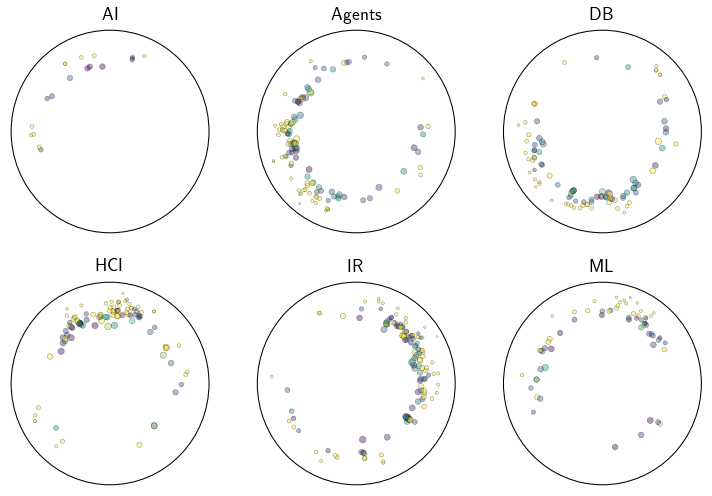

In [26]:
from matplotlib.patches import Circle


fig, axs = plt.subplots(2, 3, figsize=(12, 8))

df_features_S1_merged['x'] = df_features_S1_merged['inf_radius'] * np.cos(df_features_S1_merged['inf_theta'])
df_features_S1_merged['y'] = df_features_S1_merged['inf_radius'] * np.sin(df_features_S1_merged['inf_theta'])    

max_radius = df_features_S1_merged['inf_radius'].max()

i, j = 0, 0
for label in np.unique(df_labels['class']):
    tmp = df_features_S1_merged[df_features_S1_merged[label] > 0.5]
    axs[i, j].scatter(tmp['x'], tmp['y'],
                      s=10*np.log(tmp['inf_kappa'] + 1), c=tmp[label], 
                      edgecolors='black', alpha=0.4, linewidths=0.5, zorder=2)
    axs[i, j].set_title(label, fontsize=18)
    axs[i, j].axis('off')
    
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    axs[i, j].add_patch(circle)
    axs[i, j].set_xlim(-max_radius-1, max_radius+1)
    axs[i, j].set_ylim(-max_radius-1, max_radius+1)
    
    j += 1
    if j == 3:
        i += 1
        j = 0



In [27]:
df_features_S1_merged['class'] = df_features_S1_merged[np.unique(df_labels['class'])].idxmax(axis=1)
df_features_S1_merged

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,HCI,IR,ML,Agents,DB,AI,x,y,class
0,f5,23.61010,3.331730,17.0887,23.19970,3.331730,17.3144,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,-16.780732,-3.229658,Agents
1,f7,30.45180,2.417220,16.5798,19.91330,2.138110,17.6199,0.142857,0.0,0.142857,0.428571,0.142857,0.142857,-12.416866,10.986865,Agents
2,f9,29.45000,3.346060,16.6467,33.46080,3.535270,16.5819,0.000000,0.0,0.000000,0.090909,0.818182,0.090909,-16.299937,-3.380040,DB
3,f10,3.06664,1.144440,21.1709,4.84303,1.144440,20.4476,0.000000,0.5,0.500000,0.000000,0.000000,0.000000,8.755354,19.275653,IR
4,f14,8.12846,1.522390,19.2213,10.54700,1.522390,18.8910,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.930069,19.198785,HCI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,f3695,19.74310,4.913780,17.4465,13.57750,1.055220,18.3859,0.000000,0.2,0.600000,0.200000,0.000000,0.000000,3.489866,-17.093894,ML
914,f3696,21.85440,5.998020,17.2433,13.57750,0.406081,18.3859,0.000000,0.0,0.200000,0.400000,0.400000,0.000000,16.546932,-4.850818,Agents
915,f3697,1.05913,1.056450,23.2972,2.24190,1.057810,21.9880,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,11.461427,20.282880,IR
916,f3699,2.55940,4.174060,21.5325,4.84303,4.290420,20.4476,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,-11.039756,-18.487086,IR


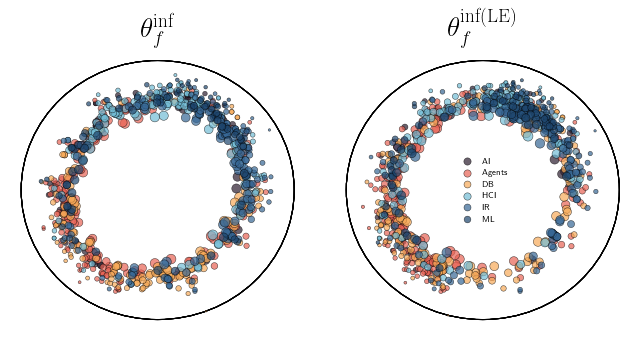

In [28]:
colormap = {label: color for color, label in zip(COLORS, np.unique(df_labels['class']))}

fig, axs = plt.subplots(1, 2, figsize=(9, 5))

max_radius = df_features_S1_merged['inf_radius'].max()

for label, group in df_features_S1_merged.groupby('class'):
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta'])    
    axs[0].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)
    
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    axs[0].add_patch(circle)
    
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta_le'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta_le'])    
    axs[1].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    axs[1].add_patch(circle)
    
    
axs[0].set_title(r'$\theta_f^{\mathrm{inf}}$')
axs[1].set_title(r'$\theta_f^{\mathrm{inf(LE)}}$')
axs[0].axis('off')
axs[1].axis('off')
axs[1].legend(fontsize=8, frameon=False)

plt.tight_layout()
